In [ ]:
!pip install pathlib
!pip install albumentations
!pip install matplotlib
import os
import xml.etree.ElementTree as ET
import cv2
import numpy as np
import random
import shutil
from pathlib import Path
import albumentations as A
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class DataAugmenter:
    def __init__(self, input_dir, output_dir, augment_factor=3):
        """
        Initialize the data augmenter

        Args:
            input_dir (str): Directory containing original images and XML files
            output_dir (str): Directory to save augmented data
            augment_factor (int): Number of augmented versions per original image
        """
        self.input_dir = Path(input_dir)
        self.output_dir = Path(output_dir)
        self.augment_factor = augment_factor
        # Create output directories
        self.output_dir.mkdir(parents=True, exist_ok=True)
        (self.output_dir / "images").mkdir(exist_ok=True)
        (self.output_dir / "labels").mkdir(exist_ok=True)

        # Define augmentation pipelines
        self.setup_augmentations()

    def pascal_to_albumentations_bbox(self, bbox, width, height):
        xmin, ymin, xmax, ymax = bbox
        return [xmin / width, ymin / height, xmax / width, ymax / height]

    def albumentations_to_pascal_bbox(self, bbox, width, height):
        xmin_norm, ymin_norm, xmax_norm, ymax_norm = bbox
        return [int(xmin_norm * width), int(ymin_norm * height), int(xmax_norm * width), int(ymax_norm * height)]

    def setup_augmentations(self):
        """Setup different augmentation pipelines"""
        bbox_params_alb = A.BboxParams(
            format='albumentations',
            label_fields=['labels']
        )

        # Pipeline 1: Geometric transformations
        self.geo_transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.RandomRotate90(p=0.5),
            A.Affine(
                translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
                scale={'x': (0.9, 1.1), 'y': (0.9, 1.1)},
                rotate=(-30, 30),
                p=0.5
            ),
        ], bbox_params=bbox_params_alb)

        # Pipeline 2: Color and lighting
        self.color_transform = A.Compose([
            A.RandomBrightnessContrast(
                brightness_limit=0.3,
                contrast_limit=0.3,
                p=0.8
            ),
            A.HueSaturationValue(
                hue_shift_limit=20,
                sat_shift_limit=30,
                val_shift_limit=20,
                p=0.7
            ),
            A.GaussNoise(p=0.3),
            A.Blur(blur_limit=3, p=0.2),
        ], bbox_params=bbox_params_alb)

        # Pipeline 3: Weather and environmental effects
        self.weather_transform = A.Compose([
            A.RandomBrightnessContrast(brightness_limit=0.2, p=0.5),
            A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.5),
            A.MotionBlur(blur_limit=3, p=0.3),
            A.MedianBlur(blur_limit=3, p=0.2),
        ], bbox_params=bbox_params_alb)

        # Pipeline 4: Combined transformations
        self.combined_transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Affine(
                translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
                scale={'x': (0.85, 1.15), 'y': (0.85, 1.15)},
                rotate=(-25, 25),
                p=0.7
            ),
            A.RandomBrightnessContrast(
                brightness_limit=0.25,
                contrast_limit=0.25,
                p=0.8
            ),
            A.HueSaturationValue(
                hue_shift_limit=15,
                sat_shift_limit=25,
                val_shift_limit=15,
                p=0.6
            ),
            A.GaussNoise(p=0.4),
        ], bbox_params=bbox_params_alb)

        # Pipeline 5: Crop and resize
        self.crop_transform = A.Compose([
            A.RandomCrop(
                height=int(3120 * 0.8),
                width=int(4160 * 0.8),
                p=0.8
            ),
            A.HorizontalFlip(p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.2, p=0.5),
        ], bbox_params=bbox_params_alb)

    def parse_xml(self, xml_path):
        """Parse XML file and extract bounding boxes"""
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Get image size
        size = root.find('size')
        img_width = int(size.find('width').text)
        img_height = int(size.find('height').text)

        # Extract objects
        objects = []
        for obj in root.findall('object'):
            name = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            objects.append({
                'name': name,
                'bbox': [xmin, ymin, xmax, ymax]
            })

        return objects, img_width, img_height

    def create_xml(self, original_xml_path, new_filename, objects, img_width, img_height):
        """Create new XML file with updated bounding boxes"""
        tree = ET.parse(original_xml_path)
        root = tree.getroot()

        # Update filename
        root.find('filename').text = new_filename
        root.find('path').text = str(self.output_dir / "images" / new_filename)

        # Update size
        root.find('size').find('width').text = str(img_width)
        root.find('size').find('height').text = str(img_height)

        # Remove old objects
        for obj in root.findall('object'):
            root.remove(obj)

        # Add new objects
        for obj_data in objects:
            obj = ET.SubElement(root, 'object')
            name = ET.SubElement(obj, 'name')
            name.text = obj_data['name']

            pose = ET.SubElement(obj, 'pose')
            pose.text = 'Unspecified'

            truncated = ET.SubElement(obj, 'truncated')
            truncated.text = '0'

            difficult = ET.SubElement(obj, 'difficult')
            difficult.text = '0'

            bndbox = ET.SubElement(obj, 'bndbox')
            xmin = ET.SubElement(bndbox, 'xmin')
            xmin.text = str(int(obj_data['bbox'][0]))
            ymin = ET.SubElement(bndbox, 'ymin')
            ymin.text = str(int(obj_data['bbox'][1]))
            xmax = ET.SubElement(bndbox, 'xmax')
            xmax.text = str(int(obj_data['bbox'][2]))
            ymax = ET.SubElement(bndbox, 'ymax')
            ymax.text = str(int(obj_data['bbox'][3]))

        return tree

    def filter_valid_bboxes(self, bboxes, labels, img_width, img_height):
        """Filter out invalid bounding boxes"""
        valid_bboxes = []
        valid_labels = []

        for bbox, label in zip(bboxes, labels):
            xmin, ymin, xmax, ymax = bbox

            # Check if bbox is valid
            if (xmin >= 0 and ymin >= 0 and
                xmax <= img_width and ymax <= img_height and
                xmax > xmin and ymax > ymin and
                (xmax - xmin) > 10 and (ymax - ymin) > 10):  # Minimum size threshold
                valid_bboxes.append(bbox)
                valid_labels.append(label)

        return valid_bboxes, valid_labels

    def augment_image(self, image_path, xml_path, augment_idx):
        """Apply augmentation to a single image and its labels"""
        try:
            # Read image
            image = cv2.imread(str(image_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Parse XML
            objects, orig_width, orig_height = self.parse_xml(xml_path)

            # Extract bboxes and labels
            pascal_bboxes = [obj['bbox'] for obj in objects]
            labels = [obj['name'] for obj in objects]

            # Convert Pascal VOC to Albumentations normalized format
            normalized_bboxes = [
                self.pascal_to_albumentations_bbox(bbox, orig_width, orig_height)
                for bbox in pascal_bboxes
            ]

            # Choose augmentation pipeline
            pipelines = [
                self.geo_transform,
                self.color_transform,
                self.weather_transform,
                self.combined_transform,
                self.crop_transform
            ]

            transform = pipelines[augment_idx % len(pipelines)]

            # Apply augmentation
            augmented = transform(image=image, bboxes=normalized_bboxes, labels=labels)
            aug_image = augmented['image']
            aug_normalized_bboxes = augmented['bboxes']
            aug_labels = augmented['labels']

            # Convert augmented normalized bboxes back to Pascal VOC absolute format
            aug_pascal_bboxes = [
                self.albumentations_to_pascal_bbox(bbox, aug_image.shape[1], aug_image.shape[0])
                for bbox in aug_normalized_bboxes
            ]

            # Filter valid bboxes (now in Pascal VOC format)
            aug_bboxes, aug_labels = self.filter_valid_bboxes(
                aug_pascal_bboxes, aug_labels, aug_image.shape[1], aug_image.shape[0]
            )

            # Skip if no valid objects remain
            if len(aug_bboxes) == 0:
                return None, None

            # Create new objects list
            aug_objects = []
            for bbox, label in zip(aug_bboxes, aug_labels):
                aug_objects.append({
                    'name': label,
                    'bbox': bbox
                })

            return aug_image, aug_objects

        except Exception as e:
            print(f"Augmentation failed for {image_path}: {e}")
            return None, None

    def process_dataset(self):
        """Process the entire dataset"""
        # Get all image files
        image_files = list(self.input_dir.glob("*.jpg"))

        print(f"Found {len(image_files)} images to process")

        processed_count = 0

        for img_path in image_files:
            # Find corresponding XML file
            xml_path = img_path.with_suffix('.xml')

            if not xml_path.exists():
                print(f"Warning: XML file not found for {img_path}")
                continue

            # Copy original files to output
            orig_img_name = img_path.name
            orig_xml_name = xml_path.name

            shutil.copy2(img_path, self.output_dir / "images" / orig_img_name)
            shutil.copy2(xml_path, self.output_dir / "labels" / orig_xml_name)

            # Create augmented versions
            for aug_idx in range(self.augment_factor):
                aug_image, aug_objects = self.augment_image(img_path, xml_path, aug_idx)

                if aug_image is None:
                    continue

                # Generate new filename
                base_name = img_path.stem
                aug_img_name = f"{base_name}_aug{aug_idx+1}.jpg"
                aug_xml_name = f"{base_name}_aug{aug_idx+1}.xml"

                # Save augmented image
                aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
                cv2.imwrite(str(self.output_dir / "images" / aug_img_name), aug_image_bgr)

                # Create and save augmented XML
                xml_tree = self.create_xml(
                    xml_path, aug_img_name, aug_objects,
                    aug_image.shape[1], aug_image.shape[0]
                )
                xml_tree.write(str(self.output_dir / "labels" / aug_xml_name),
                             encoding='utf-8', xml_declaration=True)

            processed_count += 1
            if processed_count % 5 == 0:
                print(f"Processed {processed_count}/{len(image_files)} images")

        print(f"Augmentation completed! Generated {processed_count * (self.augment_factor + 1)} total samples")

    def visualize_samples(self, num_samples=3):
        """Visualize some augmented samples"""
        img_dir = self.output_dir / "images"
        label_dir = self.output_dir / "labels"

        # Get some augmented images
        aug_images = [f for f in os.listdir(img_dir) if '_aug' in f][:num_samples]

        fig, axes = plt.subplots(num_samples, 2, figsize=(15, 5*num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)

        for i, img_name in enumerate(aug_images):
            # Load image
            img_path = img_dir / img_name
            image = cv2.imread(str(img_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Load annotations
            xml_path = label_dir / img_name.replace('.jpg', '.xml')
            objects, _, _ = self.parse_xml(xml_path)

            # Draw bounding boxes
            for obj in objects:
                bbox = obj['bbox']
                cv2.rectangle(image,
                            (int(bbox[0]), int(bbox[1])),
                            (int(bbox[2]), int(bbox[3])),
                            (255, 0, 0), 2)
                cv2.putText(image, obj['name'],
                          (int(bbox[0]), int(bbox[1]-10)),
                          cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

            # Show original and augmented
            axes[i, 0].imshow(image)
            axes[i, 0].set_title(f'Augmented: {img_name}')
            axes[i, 0].axis('off')

            # Show original for comparison
            orig_name = img_name.split('_aug')[0] + '.jpg'
            orig_path = self.input_dir / orig_name
            if orig_path.exists():
                orig_image = cv2.imread(str(orig_path))
                orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
                axes[i, 1].imshow(orig_image)
                axes[i, 1].set_title(f'Original: {orig_name}')
                axes[i, 1].axis('off')

        plt.tight_layout()
        plt.savefig(str(self.output_dir / "augmentation_samples.png"), dpi=150, bbox_inches='tight')
        plt.show()

Starting data augmentation...
Found 18 images to process
Processed 5/18 images
Processed 10/18 images
Processed 15/18 images
Augmentation completed! Generated 72 total samples
Visualizing sample augmentations...


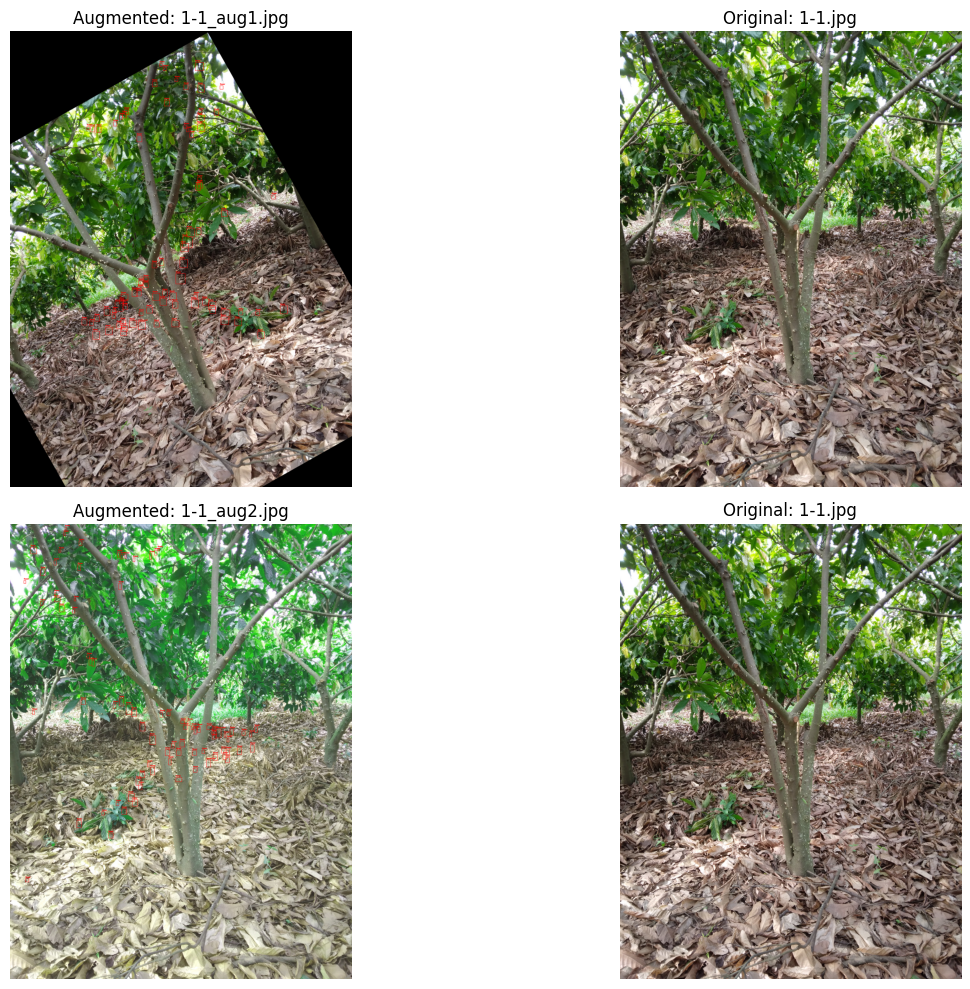

Augmentation completed! Check the output directory: /content/drive/MyDrive/deeplearning/Assignment/augmented_data
Total augmented samples generated: 4x original dataset


In [ ]:
def main():
    # Configuration
    input_directory = r"/content/drive/MyDrive/deeplearning/Assignment/Data"
    output_directory = r"/content/drive/MyDrive/deeplearning/Assignment/augmented_data"
    augmentation_factor = 3  # Number of augmented versions per original image

    # Create augmenter and process dataset
    augmenter = DataAugmenter(input_directory, output_directory, augmentation_factor)

    print("Starting data augmentation...")
    augmenter.process_dataset()

    print("Visualizing sample augmentations...")
    augmenter.visualize_samples(num_samples=2)

    print(f"Augmentation completed! Check the output directory: {output_directory}")
    print(f"Total augmented samples generated: {augmentation_factor + 1}x original dataset")


if __name__ == "__main__":
    main()